# calculates the seasonal anomalies and the seasonal tercile categories from the gridded GCM

In [1]:
# Paramaters 
provider = 'JMA'
stage_in = 'processed'
period = 'hindcasts'
GCM = 'JMA'
var_name = 'T2M'
step = 3 # note that step is not present as there are no (consistently over the period) leadtimes beyond 3 months ...it is only used here to shift the time dimension in 
# order to get the forecast valid time 
remove_tmp = True

In [69]:
nz_domain = {}
nz_domain['lat_min'] = -50.
nz_domain['lat_max'] = -20.
nz_domain['lon_min'] = 100.
nz_domain['lon_max'] = 180.

In [2]:
# gcms = ['NCEP_CFSv2','CanCM4i','CanSIPSv2', 'GEM_NEMO', 'NASA_GEOSS2S']

In [3]:
%matplotlib inline 

In [4]:
from matplotlib import pyplot as plt

In [5]:
import sys

In [6]:
sys.path.append('../../utils')

### set the root directory for loading the GCM outputs files 

In [7]:
from set_root_dir import set_root_dir

In [8]:
dpath = set_root_dir(root='gdata')

In [9]:
print(dpath)

/media/nicolasf/GDATA/END19101/Working/data


In [10]:
import os
import pathlib
from subprocess import call
import shutil

In [11]:
import salem 
import geopandas as gpd 

In [12]:
import numpy as np
import pandas as pd 

In [13]:
import xarray as xr

In [14]:
from cartopy import crs as ccrs

In [15]:
from datetime import datetime, timedelta

In [16]:
import calendar

In [17]:
import dateutil

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [18]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [19]:
var_name

'T2M'

In [20]:
GCM

'JMA'

### set the home directory 

In [21]:
HOME = pathlib.Path.home() 

### set the working directory 

In [22]:
CWD = pathlib.Path.cwd()

#### input path for the GCM outputs 

In [23]:
ipath = dpath / 'GCMs' / stage_in / period / provider / GCM / var_name

In [24]:
ipath

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/JMA/JMA/T2M')

In [25]:
lfiles_gcm = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [26]:
lfiles_gcm.sort()

In [27]:
lfiles_gcm[0]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/JMA/JMA/T2M/JMA_T2M_seasonal_anomalies_1979_01.nc')

In [28]:
lfiles_gcm[-1]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/JMA/JMA/T2M/JMA_T2M_seasonal_anomalies_2016_12.nc')

In [29]:
ncks = "/home/nicolasf/anaconda3/envs/NCO/bin/ncks"

In [30]:
tmp_path = pathlib.Path.home() / 'data' / 'tmp'

In [31]:
if not tmp_path.exists(): 
    tmp_path.mkdir(parents=True)

### read files one by one (with SALEM), calculates the ensemble mean, select the step (3) extract the domain

In [32]:
for fname in lfiles_gcm: 
    cmd = f"{ncks} -d lat,{nz_domain['lat_min']},{nz_domain['lat_max']} -d lon,{nz_domain['lon_min']},{nz_domain['lon_max']} {str(fname)} {str(tmp_path / fname.name)}"
    # cmd = f"{ncks} -d lat,-50.,-20. -d lon,100.,180. {str(fname)} {str(tmp_path / fname.name)}"
    r = call(cmd, shell=True)
    print(f"processed {fname.name}, ret code {r}")

processed JMA_T2M_seasonal_anomalies_1979_01.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_02.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_03.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_04.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_05.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_06.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_07.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_08.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_09.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_10.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_11.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1979_12.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1980_01.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1980_02.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1980_03.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_1980_04.nc, ret code 1
processed JMA_T2M_seasonal_anomalies_198

In [33]:
lfiles_tmp = list(tmp_path.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [34]:
lfiles_tmp.sort()

In [35]:
lfiles_tmp[0]

PosixPath('/home/nicolasf/data/tmp/JMA_T2M_seasonal_anomalies_1979_01.nc')

In [36]:
lfiles_tmp[-1]

PosixPath('/home/nicolasf/data/tmp/JMA_T2M_seasonal_anomalies_2016_12.nc')

In [37]:
dset_l = []
time_l = []
for fname in lfiles_tmp: 
    dset = salem.open_xr_dataset(fname)
    # here make sure that we drop potentially conflicting variables and coordinates
    if 'surface' in dset.variables: 
        dset = dset.drop('surface') 
    if 'valid_time' in dset.coords: 
        dset = dset.drop('valid_time')
#     dset = dset.mean('member') # no ensemble, so no member ... 
    time = pd.to_datetime(dset.time.data) + dateutil.relativedelta.relativedelta(month=step + 1)
    time_l.append(time)
    dset_l.append(dset)

In [38]:
dset = xr.concat(dset_l, dim='time')

In [40]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 33, time: 456)
Coordinates:
  * lat      (lat) float64 -50.0 -47.5 -45.0 -42.5 ... -27.5 -25.0 -22.5 -20.0
  * lon      (lon) float64 100.0 102.5 105.0 107.5 ... 172.5 175.0 177.5 180.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Data variables:
    t2m      (time, lat, lon) float64 -0.151 -0.2023 -0.2523 ... 2.073 2.072
Attributes:
    history:     Wed Mar 25 13:00:24 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### only needed if the forecast period is mistakenly included in the hindcast folder 

In [41]:
if pd.to_datetime(dset.time[-1].data).year > 2016: 
    dset = dset.sel(time=slice(None, '2016')) # only needed if 

### shift the time index, to reflect the actual forecast valid time 

In [43]:
dset['time'] = dset.time.to_index().shift(step + 1, freq='M')

In [44]:
dset.time[0].data

array('1979-04-30T00:00:00.000000000', dtype='datetime64[ns]')

In [45]:
dset.time[-1].data

array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')

In [46]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 33, time: 456)
Coordinates:
  * lat      (lat) float64 -50.0 -47.5 -45.0 -42.5 ... -27.5 -25.0 -22.5 -20.0
  * lon      (lon) float64 100.0 102.5 105.0 107.5 ... 172.5 175.0 177.5 180.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-04-30 1979-05-31 ... 2017-03-31
Data variables:
    t2m      (time, lat, lon) float64 -0.151 -0.2023 -0.2523 ... 2.073 2.072
Attributes:
    history:     Wed Mar 25 13:00:24 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### reads the NZ 6 regions shapefiles 

In [48]:
nz_regions = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp')

In [49]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


### change the CRS to WGS84 / EPSG 4326 

In [50]:
nz_regions = nz_regions.to_crs(epsg=4326)

In [51]:
nz_regions.crs

{'init': 'epsg:4326', 'no_defs': True}

### creates the output path 

In [52]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'GCMs' / 'NZ_6_regions' / GCM / var_name

In [53]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [54]:
num_quantiles = 3

In [55]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [56]:
quant_values = quant_values[1:-1]

In [57]:
quant_values

array([0.33333333, 0.66666667])

In [58]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [67]:
col_labs

['Q33', 'Q66']

### the JMA outputs need to be interpolated onto a finer grid, or else doesnt work 

In [70]:
target_grid = xr.open_dataset(pathlib.Path(set_root_dir(root='local') / 'GCMs' / 'target_grid' / 'target_grid_1x1.nc'))

In [71]:
target_grid = target_grid.sel(lat=slice(nz_domain['lat_min'], nz_domain['lat_max']), lon=slice(nz_domain['lon_min'], nz_domain['lon_max']))

In [72]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 33, time: 456)
Coordinates:
  * lat      (lat) float64 -50.0 -47.5 -45.0 -42.5 ... -27.5 -25.0 -22.5 -20.0
  * lon      (lon) float64 100.0 102.5 105.0 107.5 ... 172.5 175.0 177.5 180.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-04-30 1979-05-31 ... 2017-03-31
Data variables:
    t2m      (time, lat, lon) float64 -0.151 -0.2023 -0.2523 ... 2.073 2.072
Attributes:
    history:     Wed Mar 25 13:00:24 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

In [74]:
dset = dset.interp_like(target_grid)

In [75]:
dset

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 80, time: 456)
Coordinates:
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-04-30 1979-05-31 ... 2017-03-31
  * lat      (lat) float64 -49.5 -48.5 -47.5 -46.5 ... -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
Data variables:
    t2m      (time, lat, lon) float64 -0.1758 -0.1933 -0.2109 ... 2.104 2.102
Attributes:
    history:     Wed Mar 25 13:00:24 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### plots the regions for the GCMs grid 

In [77]:
region_name

'WSI'

In [86]:
shape = nz_regions.query(f"Location == '{region_name}'")

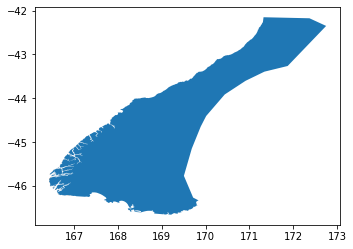

In [87]:
shape.plot()

In [88]:
region = dset.salem.subset(shape=shape, margin=1)

In [89]:
region

<xarray.Dataset>
Dimensions:  (lat: 7, lon: 8, time: 456)
Coordinates:
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-04-30 1979-05-31 ... 2017-03-31
  * lat      (lat) float64 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5
  * lon      (lon) float64 166.5 167.5 168.5 169.5 170.5 171.5 172.5 173.5
Data variables:
    t2m      (time, lat, lon) float64 -0.5685 -0.6076 -0.5711 ... 2.365 2.183
Attributes:
    history:     Wed Mar 25 13:00:24 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

In [90]:
region = region.salem.roi(shape=shape, all_touched=True)

Trying to process region NNI
Trying to process region WNI
Trying to process region ENI
Trying to process region NSI
Trying to process region ESI
Trying to process region WSI


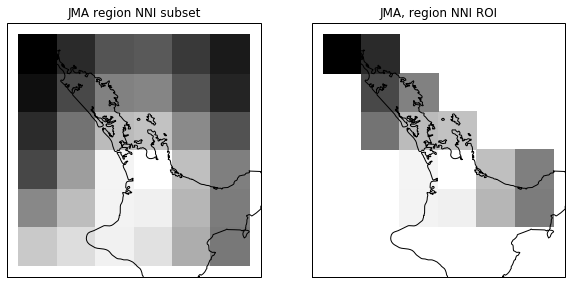

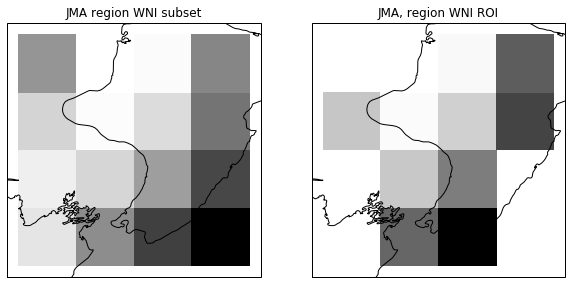

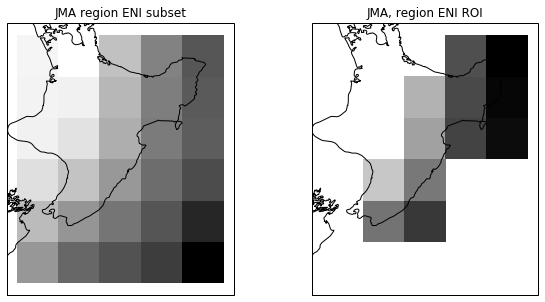

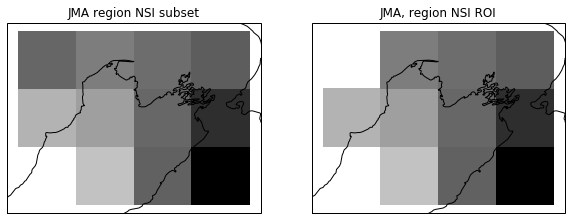

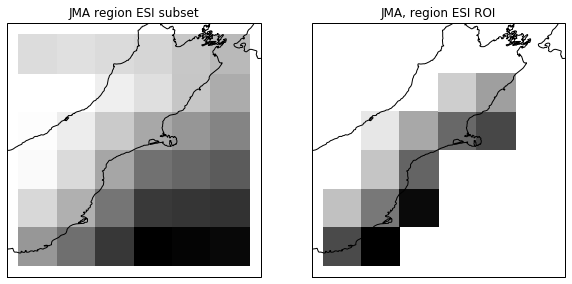

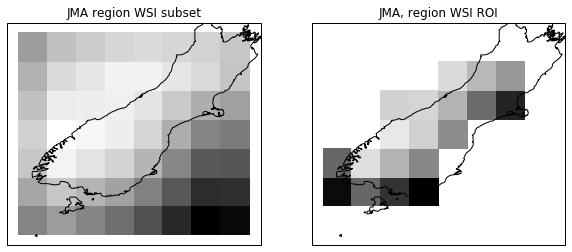

In [91]:
for region_name in nz_regions.Location.values:
    
    print(f"Trying to process region {region_name}")
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    f, axes = plt.subplots(figsize=(10, 5), ncols=2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}) 

    region = dset.salem.subset(shape=shape, margin=1)

    region[var_name.lower()][0,:,:].plot(ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

    axes[0].coastlines(resolution='10m')

    axes[0].set_title(f'{GCM} region {region_name} subset')

    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)

        region[var_name.lower()][0,:,:].plot(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

        axes[1].coastlines(resolution='10m')

        axes[1].set_title(f'{GCM}, region {region_name} ROI')

    f.savefig(CWD.parents[2] / 'figures' / f'subset_and_ROI_map_{GCM}_{region_name}.png', dpi=200, bbox_inches='tight')

### Now loops over the regions names, extract, calculate regional index and save to file 

In [92]:
quantiles_dict = {}

for region_name in nz_regions.Location.values: 
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    region = dset.salem.subset(shape=shape, margin=1)
    
    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)
        
    else: 
        
        print(f"Warning: region {region_name} boundaries do not allow the ROI to be calculated")
    
    # if there's useless dimension 'Z', drop from the dataset 
    
    if 'Z' in region.dims: 
        region = region.sel(Z = region.Z.data[0])
        region = region.drop('Z')
    
    ts = region.mean(dim=['lat','lon'])
    
    ts_df = ts[var_name.lower()].to_dataframe()
            
    ts_series = ts_df.loc[:,var_name.lower()]
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        ts_series_m = ts_series[ts_series.index.month == month]
        
        clim = ts_series_m.loc['1993':'2016']
        
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name.lower()]
    
    ts_df = ts_df.loc[:,['month',f'cat_{num_quantiles}','anomalies']]
    
    opath = opath_root / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{GCM}_{var_name}_{num_quantiles}_quantiles_anoms.csv')
    
    #descriptive statistics per quantile category 
    
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}_{GCM}_{var_name}_{num_quantiles}.csv')
    
    print(f"region {region_name} processed for variable {var_name} in {GCM}")
    

region NNI processed for variable T2M in JMA
region WNI processed for variable T2M in JMA
region ENI processed for variable T2M in JMA
region NSI processed for variable T2M in JMA
region ESI processed for variable T2M in JMA
region WSI processed for variable T2M in JMA


In [93]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/WSI')

### saves the climatological terciles calculated from the VCSN regional aggregates

In [94]:
quantiles_list = []
for region_name in nz_regions.Location.values: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [95]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [96]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/WSI')

In [97]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{var_name}.csv')

In [98]:
quantiles_df

NNI                 WNI                 ENI                 NSI  \
             Q33       Q66       Q33       Q66       Q33       Q66       Q33   
season                                                                         
1      -0.384331  0.188854 -0.362939  0.160126 -0.320349  0.179375 -0.343402   
2      -0.355717  0.255163 -0.391968  0.219173 -0.347414  0.136801 -0.478248   
3      -0.298992 -0.001150 -0.352212  0.018312 -0.291877  0.001951 -0.358575   
4      -0.273419 -0.005866 -0.326557  0.092059 -0.285415  0.052561 -0.386324   
5      -0.273383  0.004496 -0.279316  0.047605 -0.288137 -0.015056 -0.331436   
6      -0.295031  0.134621 -0.326666  0.192648 -0.311306  0.164384 -0.311437   
7      -0.090591  0.171564 -0.045855  0.179218 -0.135002  0.204678 -0.076556   
8      -0.062862  0.266936 -0.014393  0.355662  0.020274  0.345741  0.002906   
9      -0.035261  0.292241 -0.025833  0.335900  0.073722  0.263685 -0.150176   
10     -0.035208  0.274556 -0.008172  0.271570 -0.018931  0.236725 -0.083519   
11     -0.020754  0.298415 -0.052246  0.300528 -0.001315  0.300640 -0.104714   
12     -0.065831  0.323046 -0.148121  0.277951 -0.112888  0.256610 -0.227016   

                       ESI                 WSI            
             Q66       Q33       Q66       Q33       Q66  
season                                                    
1       0.165654 -0.243573  0.157759 -0.240685  0.158003  
2       0.234660 -0.489482  0.301559 -0.577173  0.289758  
3      -0.002584 -0.323832 -0.036786 -0.356282 -0.010331  
4       0.045959 -0.381671 -0.024965 -0.387143 -0.039969  
5       0.113656 -0.331328  0.097516 -0.343417  0.084133  
6       0.161496 -0.254382  0.119348 -0.287827  0.157176  
7       0.104153 -0.054383  0.122835 -0.110719  0.081791  
8       0.235521  0.043805  0.150772 -0.020830  0.126084  
9       0.338111 -0.040944  0.378370 -0.114674  0.314838  
10      0.240992 -0.051817  0.258765 -0.122591  0.240142  
11      0.336795 -0.133468  0.295631 -0.134302  0.268385  
12      0.285088 -0.183451  0.221194 -0.197101  0.218080

### plots the anomalies and the categories 

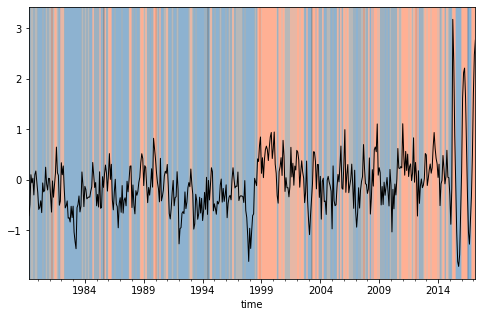

In [99]:
f, ax = plt.subplots(figsize=(8,5))
ts_df.anomalies.plot(lw=1, color='k', zorder=0)
cats = pd.to_numeric(ts_df.cat_3)
[ax.axvline(x, color='steelblue', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 1),].index];
[ax.axvline(x, color='k', alpha=0.2, lw=1.5, zorder=-10) for x in cats.loc[(cats == 2),].index];
[ax.axvline(x, color='coral', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 3),].index];
f.savefig('/home/nicolasf/Desktop/essai.png', dpi=200, bbox_inches='tight')

In [ ]:
tmp_path

In [ ]:
if remove_tmp: 
    shutil.rmtree(tmp_path)

In [ ]:
print(f"\n\n\nPROCESSING FINISHED FOR {GCM} -> {var_name}")

In [100]:
df

WSI          
             Q33       Q66
season                    
1      -0.240685  0.158003
2      -0.577173  0.289758
3      -0.356282 -0.010331
4      -0.387143 -0.039969
5      -0.343417  0.084133
6      -0.287827  0.157176
7      -0.110719  0.081791
8      -0.020830  0.126084
9      -0.114674  0.314838
10     -0.122591  0.240142
11     -0.134302  0.268385
12     -0.197101  0.218080

In [110]:
!ls /home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M

Climatological_quantiles_3_cat_T2M.csv	ENI  ESI  NNI  NSI  WNI  WSI


In [113]:
lfiles_csv = list((opath.parent).rglob("TS_NZ_region_*_JMA_T2M_3_quantiles_anoms.csv"))

In [114]:
lfiles_csv

[PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/NNI/TS_NZ_region_NNI_JMA_T2M_3_quantiles_anoms.csv'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/WNI/TS_NZ_region_WNI_JMA_T2M_3_quantiles_anoms.csv'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/ENI/TS_NZ_region_ENI_JMA_T2M_3_quantiles_anoms.csv'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/WSI/TS_NZ_region_WSI_JMA_T2M_3_quantiles_anoms.csv'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/ESI/TS_NZ_region_ESI_JMA_T2M_3_quantiles_anoms.csv'),
 PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M/NSI/TS_NZ_region_NSI_JMA_T2M_3_quantiles_anoms.csv')]

In [123]:
fname.name.split('_')[3]

'NNI'

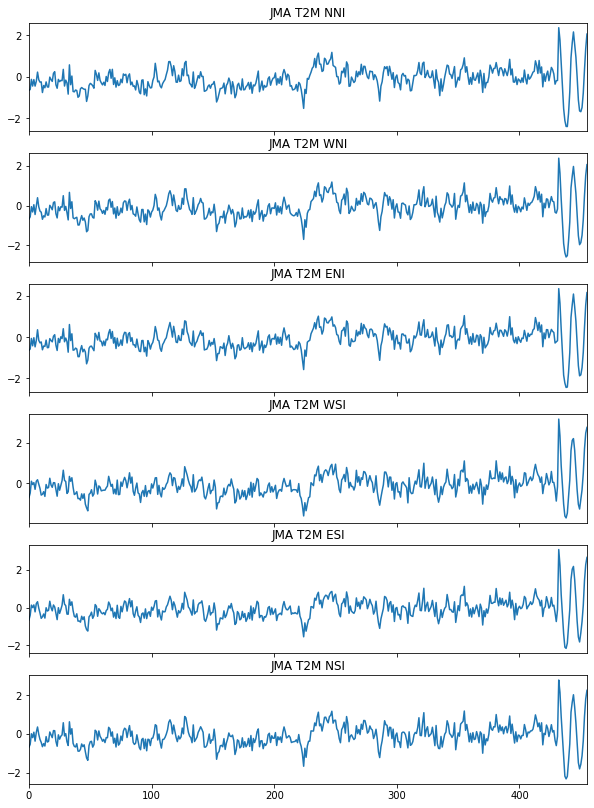

In [127]:
f, axes = plt.subplots(nrows=6, figsize=(10, 14), sharex=True)
for i in range(6): 
    fname = lfiles_csv[i]
    name = fname.name.split('_')[3]
    data = pd.read_csv(fname)
    data.anomalies.plot(ax=axes[i])
    axes[i].set_title(f"{GCM} {var_name} {name}")

In [109]:
opath.parent

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/JMA/T2M')

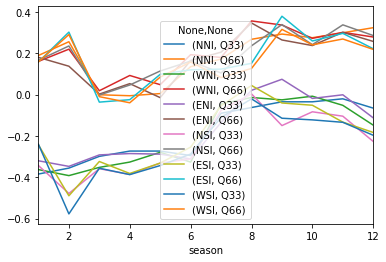

In [103]:
quantiles_df.plot() 